In [160]:
#Set up the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier


In [161]:
#Set up the dataframe
df = pd.read_csv('data/NBA Shot Locations 1997 - 2020.csv')
df.head(3)

,Game ID,Game Event ID,Player ID,Player Name,Team ID,Team Name,Period,Minutes Remaining,Seconds Remaining,Action Type,...,Shot Zone Area,Shot Zone Range,Shot Distance,X Location,Y Location,Shot Made Flag,Game Date,Home Team,Away Team,Season Type
0,29700427,389,100,Tim Legler,1610612764,Washington Wizards,4,11,22,Jump Shot,...,Right Side(R),8-16 ft.,15,117,109,1,19980102,WAS,IND,Regular Season
1,29700427,406,100,Tim Legler,1610612764,Washington Wizards,4,9,36,Jump Shot,...,Right Side(R),8-16 ft.,14,143,25,0,19980102,WAS,IND,Regular Season
2,29700427,475,100,Tim Legler,1610612764,Washington Wizards,4,3,7,Jump Shot,...,Left Side(L),8-16 ft.,10,-87,55,0,19980102,WAS,IND,Regular Season


In [502]:
#Test Data Frame will be LeBron James, Raptors Player, PG
#df[df.name.isin(li)]
playertest = ['LeBron James', 'Kyle Lowry','Stephen Curry','Kevin Durant',
              'James Harden','Russell Westbrook','Damian Lillard','Kawhi Leonard',
              'Kyrie Irving','Bradley Beal']
test_df=df[df['Player Name'].isin(playertest)]
test_df['Player Name'].value_counts()

LeBron James         29658
Kevin Durant         18731
Russell Westbrook    18547
James Harden         15688
Stephen Curry        14102
Damian Lillard       12040
Kyle Lowry           11180
Kyrie Irving         10486
Bradley Beal          9945
Kawhi Leonard         8565
Name: Player Name, dtype: int64

In [479]:
test_df=df[df['Player Name']=='Jayson Tatum']

In [480]:
test_df.columns

Index(['Game ID', 'Game Event ID', 'Player ID', 'Player Name', 'Team ID',
       'Team Name', 'Period', 'Minutes Remaining', 'Seconds Remaining',
       'Action Type', 'Shot Type', 'Shot Zone Basic', 'Shot Zone Area',
       'Shot Zone Range', 'Shot Distance', 'X Location', 'Y Location',
       'Shot Made Flag', 'Game Date', 'Home Team', 'Away Team', 'Season Type'],
      dtype='object')

In [503]:
test_df['Shot Type'].value_counts()

2PT Field Goal    100410
3PT Field Goal     48532
Name: Shot Type, dtype: int64

In [504]:
DT_df= test_df.drop(['Team ID','Player ID',
                     'Player Name','Game Event ID', 'Team Name','X Location', 'Y Location', 
                     'Home Team','Away Team','Season Type','Action Type','Shot Zone Basic'
                    ],axis=1)

In [505]:
DT_df.shape

(148942, 10)

In [506]:
#Rebuild the DF
#idka=pd.get_dummies(DT_df['Action Type'])
idkb=pd.get_dummies(DT_df['Shot Type'])
#idkc=pd.get_dummies(DT_df['Shot Zone Basic'])
idkd=pd.get_dummies(DT_df['Shot Zone Range'])
idk = pd.concat([DT_df, idkb, idkd], axis=1, sort=False)
idk=idk.drop(['Shot Type','Shot Zone Range'],axis=1)
idk

,Game ID,Period,Minutes Remaining,Seconds Remaining,Shot Zone Area,Shot Distance,Shot Made Flag,Game Date,2PT Field Goal,3PT Field Goal,16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.
1194060,20300014,1,8,56,Right Side(R),15,1,20031029,1,0,0,0,1,0,0
1194061,20300014,1,7,44,Left Side(L),13,1,20031029,1,0,0,0,1,0,0
1194062,20300014,1,7,1,Right Side(R),16,1,20031029,1,0,1,0,0,0,0
1194063,20300014,1,6,29,Left Side(L),14,0,20031029,1,0,0,0,1,0,0
1194064,20300014,1,4,48,Center(C),5,1,20031029,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4725932,41800314,4,0,31,Center(C),30,0,20190520,0,1,0,1,0,0,0
4725933,41800314,4,0,0,Center(C),5,0,20190520,1,0,0,0,0,0,1
4725934,41800314,5,0,32,Center(C),0,1,20190520,1,0,0,0,0,0,1
4725935,41800314,5,0,3,Center(C),2,0,20190520,1,0,0,0,0,0,1


In [507]:
#Lets drop Back court as there are only 52 shots
idk.drop(idk[idk['Shot Zone Area'] == 'Back Court(BC)'].index,inplace=True)
idk

,Game ID,Period,Minutes Remaining,Seconds Remaining,Shot Zone Area,Shot Distance,Shot Made Flag,Game Date,2PT Field Goal,3PT Field Goal,16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.
1194060,20300014,1,8,56,Right Side(R),15,1,20031029,1,0,0,0,1,0,0
1194061,20300014,1,7,44,Left Side(L),13,1,20031029,1,0,0,0,1,0,0
1194062,20300014,1,7,1,Right Side(R),16,1,20031029,1,0,1,0,0,0,0
1194063,20300014,1,6,29,Left Side(L),14,0,20031029,1,0,0,0,1,0,0
1194064,20300014,1,4,48,Center(C),5,1,20031029,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4725932,41800314,4,0,31,Center(C),30,0,20190520,0,1,0,1,0,0,0
4725933,41800314,4,0,0,Center(C),5,0,20190520,1,0,0,0,0,0,1
4725934,41800314,5,0,32,Center(C),0,1,20190520,1,0,0,0,0,0,1
4725935,41800314,5,0,3,Center(C),2,0,20190520,1,0,0,0,0,0,1


In [508]:
#Roll up the columns
idk.loc[idk['Shot Zone Area'] == 'Left Side Center(LC)' , ['Shot Zone Area']] = 'Left Side(L)'
idk.loc[idk['Shot Zone Area'] == 'Right Side Center(RC)' , ['Shot Zone Area']] = 'Right Side(R)'

In [509]:
idk['Shot Zone Area'].value_counts()

Center(C)        77683
Left Side(L)     36004
Right Side(R)    34916
Name: Shot Zone Area, dtype: int64

In [510]:
#Encoding our target
from sklearn.preprocessing import LabelEncoder

# Instantiate the label encoder
le = LabelEncoder()

# Fit and transform the order priority column
idk['Shot Zone Area']=le.fit_transform(idk['Shot Zone Area'])

In [511]:
idk['Shot Zone Area'].value_counts()

0    77683
1    36004
2    34916
Name: Shot Zone Area, dtype: int64

In [512]:
#Split first
from sklearn.model_selection import train_test_split
X = idk.drop(['Shot Zone Area'],axis=1)
y = idk['Shot Zone Area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [513]:
#Now lets scale
#Scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

my_minmax_scaler = MinMaxScaler()

my_minmax_scaler = my_minmax_scaler.fit(X_train)

X_train = my_minmax_scaler.transform(X_train)

X_test = my_minmax_scaler.transform(X_test)



In [514]:
#Now lets use PCA to reduce dimensions
from sklearn.decomposition import PCA

start = time.time()

#we want to explain at least 90% of the variance
my_pca = PCA(n_components=.9)
my_pca.fit(X_train)

# transform data
X_train_PCA = my_pca.transform(X_train)

# Transform test data
X_test_PCA = my_pca.transform(X_test)

#print the time
end = time.time()
print(end - start)

0.06522989273071289


In [515]:
X_train.shape

(118882, 14)

In [217]:
X_train_PCA.shape

(23684, 8)

In [218]:
X_train_PCA.shape[1]

8

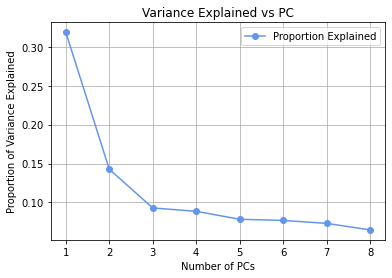

In [219]:
#Setting up the explained variance
expl_var = my_pca.explained_variance_ratio_
#Setting up the plot
plt.figure()
plt.plot(range(1,(X_test_PCA.shape[1]+1),1),expl_var,color='cornflowerblue',label='Proportion Explained',marker='o')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.legend()
plt.title('Variance Explained vs PC')
plt.grid()
plt.show()

In [143]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

### 5-fold cross validation
cross_validation_scores = []
# The C_values to try
C_values = [.00001,0.0001,0.001, 0.01, 0.1, 1, 10, 100,1000]

#Do some cross validation
for c in tqdm(C_values):
    #fit the log model
    LR_model = LogisticRegression(C=c,max_iter=100)
    #set the cross validation
    cv_score = np.mean(cross_val_score(LR_model, X_train_PCA, y_train, cv = 5))
    #gather the scores for validation
    cross_validation_scores.append(cv_score)

100%|██████████| 9/9 [00:04<00:00,  2.15it/s]


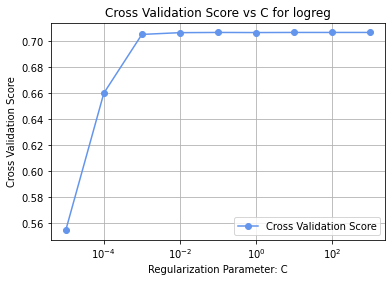

The best model has C =  0.1


In [144]:
# Plot
plt.figure()
plt.plot(C_values, cross_validation_scores,c='cornflowerblue',label="Cross Validation Score",marker='o')
plt.legend()
plt.title('Cross Validation Score vs C for logreg')
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')

plt.grid()
plt.show();

which_max = np.array(cross_validation_scores).argmax()

print("The best model has C = ",C_values[which_max])

In [145]:
# Lets print the score of the highest 
# Instantiate the model
log_reg = LogisticRegression(C=C_values[which_max],max_iter=100)

# Fit the model 
log_reg.fit(X_train_PCA,y_train)

# evaluate on train & test sets
print(f'Train Score for Logistical Regression = {round(log_reg.score(X_train_PCA, y_train),3)}')
print(f'Test Score for Logistical Regression = {round(log_reg.score(X_test_PCA, y_test),3)}')

Train Score for Logistical Regression = 0.707
Test Score for Logistical Regression = 0.715


100%|██████████| 9/9 [00:00<00:00, 115.39it/s]


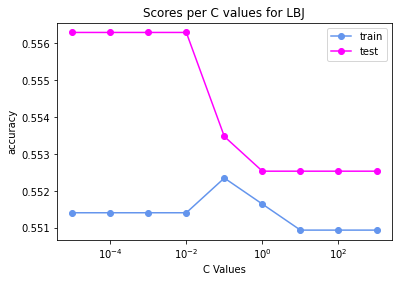

0.331528902053833


In [210]:
from sklearn.linear_model import LogisticRegression

start = time.time()
# Create lists to hold our accuracies
train_acc = []
test_acc = []

# The C_values to try
C_values = [.00001,0.0001,0.001, 0.01, 0.1, 1, 10, 100,1000]



# Loop through the C values 
for C in tqdm(C_values):

    # Instantiate the model
    log_reg = LogisticRegression(C=C,max_iter=1000,solver='lbfgs')

    # Fit the model 
    log_reg.fit(X_train_PCA,y_train)

    # Score the model 
    train_acc.append(log_reg.score(X_train_PCA,y_train))
    test_acc.append(log_reg.score(X_test_PCA,y_test))

# plot the results
plt.figure()
plt.plot(C_values,train_acc, c='cornflowerblue', label='train', marker="o")
plt.plot(C_values,test_acc, c='fuchsia', label='test', marker="o")
plt.title('Scores per C values for LBJ')
plt.xlabel('C Values')
plt.ylabel('accuracy')
plt.xscale('log')
plt.legend()
plt.show()

end=time.time()
print(end-start)

In [118]:
from sklearn.metrics import confusion_matrix

y_pred = log_reg.predict(X_test_PCA)

# True values first, predicted values second
confusion_matrix(y_test, y_pred)

array([[761, 238, 195],
       [ 80, 367, 318],
       [ 79, 387, 375]])

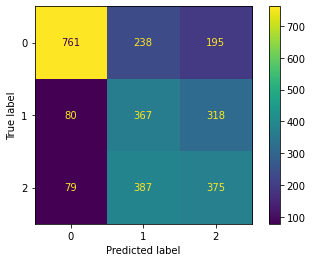

In [119]:
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [120]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.83      0.64      0.72      1194
           1       0.37      0.48      0.42       765
           2       0.42      0.45      0.43       841

    accuracy                           0.54      2800
   macro avg       0.54      0.52      0.52      2800
weighted avg       0.58      0.54      0.55      2800



In [121]:
idk['Shot Zone Area'].value_counts(normalize=True)

0    0.432062
2    0.287827
1    0.280111
Name: Shot Zone Area, dtype: float64

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB

In [27]:
from sklearn.neural_network import MLPClassifier
# MLP: multilayer perceptron

In [423]:
# Set up the (placeholder) pipeline 
pipeline = Pipeline([('scale', MinMaxScaler()),
                    ('decompose', PCA()),
                    ('model', LogisticRegression())])

# Set up the parameter grid
param_grid = [
            {
                'scale':[MinMaxScaler(), StandardScaler()],
                'model':[LogisticRegression(max_iter=1000000)],
                'decompose':[PCA()],
                'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'model__penalty':['l1','l2'],
                'model__solver':['lbfgs', 'liblinear', 'saga'],
                'decompose__n_components': [.9]
                
            }, {
                'scale':[MinMaxScaler(), StandardScaler()],
                'model':[RandomForestClassifier()],
                'decompose':[PCA()],
                'model__max_depth': [1,2,3,4,5,7],
                'decompose__n_components': [.9]
            }, {
                'scale':[MinMaxScaler(), StandardScaler()],
                'model':[GradientBoostingClassifier()],
                'decompose':[PCA()],
                'model__max_depth': [1,2,3,4,5],
                'decompose__n_components': [.9]
            }, {
                'scale':[MinMaxScaler(), StandardScaler()],
                'model':[MultinomialNB()],
                'decompose':[PCA()],
                'model__alpha': [0.00001,0.0001, 0.001, 0.01, 0.1, 1, 2],
                'decompose__n_components': [.9]
            }]
            
# Instantiate the grid search
my_gridsearch = GridSearchCV(pipeline, param_grid, n_jobs=3,verbose=1)

# Fit the grid search
my_gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   11.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.8min
[Parallel(n_jobs=3)]: Done 600 out of 600 | elapsed: 36.6min finished


GridSearchCV(estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('decompose', PCA()),
                                       ('model', LogisticRegression())]),
             n_jobs=3,
             param_grid=[{'decompose': [PCA()],
                          'decompose__n_components': [0.9],
                          'model': [LogisticRegression(max_iter=1000000)],
                          'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'model__penalty': ['l1', 'l2'],
                          'model__solver': ['lbfgs', 'liblinear', 'sag...
                          'scale': [MinMaxScaler(), StandardScaler()]},
                         {'decompose': [PCA()],
                          'decompose__n_components': [0.9],
                          'model': [GradientBoostingClassifier()],
                          'model__max_depth': [1, 2, 3, 4, 5],
                          'scale': [MinMaxScaler(), StandardScaler()]},
   

In [379]:
# Set up the (placeholder) pipeline 
pipeline = Pipeline([('scale', MinMaxScaler()),
                    ('decompose', PCA()),
                    ('model', LogisticRegression())])

# Set up the parameter grid
param_grid = [
            {
                'scale':[MinMaxScaler(), StandardScaler()],
                'model':[LogisticRegression(max_iter=1000000)],
                'decompose':[PCA()],
                'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'model__penalty':['l1','l2'],
                'model__solver':['lbfgs', 'liblinear', 'saga'],
                'model__class_weight':[{0:1,1:2,2:2.5}],
                'decompose__n_components': [.9]
                
            }]
            
# Instantiate the grid search
my_gridsearch_rw = GridSearchCV(pipeline, param_grid, n_jobs=3,verbose=1)

# Fit the grid search
my_gridsearch_rw.fit(X_train,y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   10.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 420 out of 420 | elapsed: 10.3min finished


GridSearchCV(estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('decompose', PCA()),
                                       ('model', LogisticRegression())]),
             n_jobs=3,
             param_grid=[{'decompose': [PCA(n_components=0.9)],
                          'decompose__n_components': [0.9],
                          'model': [LogisticRegression(C=1,
                                                       class_weight={2: 1.07},
                                                       max_iter=1000000,
                                                       solver='liblinear')],
                          'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'model__class_weight': [{2: 1.07}],
                          'model__penalty': ['l1', 'l2'],
                          'model__solver': ['lbfgs', 'liblinear', 'saga'],
                          'scale': [MinMaxScaler(), StandardScaler()]}],
             verbos

In [424]:
# Best estimator object
my_gridsearch.best_estimator_

Pipeline(steps=[('scale', MinMaxScaler()), ('decompose', PCA(n_components=0.9)),
                ('model', RandomForestClassifier(max_depth=7))])

In [425]:
print(my_gridsearch.score(X_train, y_train))
print(my_gridsearch.score(X_test, y_test))

0.6262428290237378
0.6134046633693349


In [500]:
from sklearn.metrics import confusion_matrix

y_pred = my_gridsearch.predict(X_test)

# True values first, predicted values second
confusion_matrix(y_test, y_pred)

array([[  0,   0, 340],
       [  0,   0, 147],
       [  0,   0, 184]])

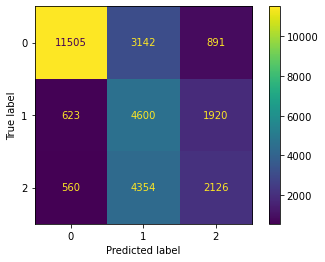

In [427]:
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [428]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.91      0.74      0.82     15538
           1       0.38      0.64      0.48      7143
           2       0.43      0.30      0.36      7040

    accuracy                           0.61     29721
   macro avg       0.57      0.56      0.55     29721
weighted avg       0.67      0.61      0.63     29721



In [429]:
idk['Shot Zone Area'].value_counts(normalize=True)

0    0.522755
1    0.242283
2    0.234962
Name: Shot Zone Area, dtype: float64

Grid Search NN

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [198]:
#Set up the (placeholder) pipeline 
pipeline = Pipeline([('scale', MinMaxScaler()),
                    ('decompose', PCA()),
                    ('model', LogisticRegression())])

# Set up the parameter grid
param_grid = [
            {
                'scale':[MinMaxScaler(), StandardScaler()],
                'model':[MLPClassifier()],
                'decompose':[PCA()],
                'model__solver':['sgd','Adam'],
                'model__hidden_layer_sizes':np.arange(5, 12),
                'model__alpha': 10.0 ** -np.arange(1, 7),
                'decompose__n_components': [.9]
            } ]
            
# Instantiate the grid search
my_gridsearch = GridSearchCV(pipeline, param_grid, n_jobs=3,verbose=1)

# Fit the grid search
my_gridsearch.fit(X_train,y_train)
print("-----------------Original Features--------------------")
print("Best score: %0.4f" % my_gridsearch.best_score_)
print("Using the following parameters:")
print(my_gridsearch.best_params_)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   17.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  4.5min
[Parallel(n_jobs=3)]: Done 840 out of 840 | elapsed:  4.7min finished


-----------------Original Features--------------------
Best score: 0.7059
Using the following parameters:
{'decompose': PCA(n_components=0.9), 'decompose__n_components': 0.9, 'model': MLPClassifier(hidden_layer_sizes=6, solver='sgd'), 'model__alpha': 0.0001, 'model__hidden_layer_sizes': 6, 'model__solver': 'sgd', 'scale': StandardScaler()}


In [199]:
# Best estimator object
my_gridsearch.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('decompose', PCA(n_components=0.9)),
                ('model', MLPClassifier(hidden_layer_sizes=6, solver='sgd'))])

In [200]:
print(my_gridsearch.score(X_train, y_train))
print(my_gridsearch.score(X_test, y_test))

0.7039773686877216
0.7109084768659236


Log reg

                 LogisticRegression(C=1, class_weight={2: 1.07},
                                    max_iter=1000000, solver='liblinear'))])

In [516]:
# Instantiate the model
log_reg = LogisticRegression(C=1,max_iter=100000,solver='liblinear',class_weight={0:1,1:2,2:2.2},random_state=1)

# Fit the model 
log_reg.fit(X_train_PCA,y_train)

# evaluate on train & test sets
print(f'Train Score for Logistical Regression = {round(log_reg.score(X_train_PCA, y_train),3)}')
print(f'Test Score for Logistical Regression = {round(log_reg.score(X_test_PCA, y_test),3)}')

Train Score for Logistical Regression = 0.605
Test Score for Logistical Regression = 0.61


In [517]:
from sklearn.metrics import confusion_matrix

y_pred = log_reg.predict(X_test_PCA)

# True values first, predicted values second
confusion_matrix(y_test, y_pred)

array([[10824,  2666,  2048],
       [    0,  3434,  3709],
       [    3,  3173,  3864]])

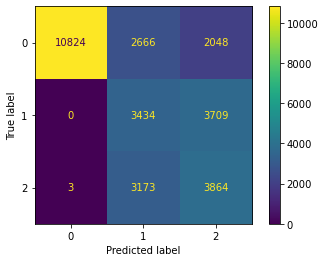

In [518]:
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [519]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       1.00      0.70      0.82     15538
           1       0.37      0.48      0.42      7143
           2       0.40      0.55      0.46      7040

    accuracy                           0.61     29721
   macro avg       0.59      0.58      0.57     29721
weighted avg       0.71      0.61      0.64     29721



In [520]:
idk['Shot Zone Area'].value_counts(normalize=True)

0    0.522755
1    0.242283
2    0.234962
Name: Shot Zone Area, dtype: float64

In [499]:
y_pred[1]

0